In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing as pp

from tensorflow.keras.layers import Embedding,SimpleRNN,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import logging
import numpy as np
import pandas as pd 
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
''' Load Data '''
#  Only want the top 10,000 words that most frequently occurred in the training dataset

((XTr,YTr),(XTe,YTe)) = imdb.load_data(num_words=10000) # tuple of numpy arrays

print("The length of the Training Dataset is ", len(XTr),' reviews')
print("The length of the Testing Dataset is ", len(XTe),' reviews')

17473536/17464789 [==============================] - 0s 0us/step
The length of the Training Dataset is  25000  reviews
The length of the Testing Dataset is  25000  reviews


In [3]:
''' Print Example '''
# numeric representation of the words

print(f'\nReview:\n{XTr[0]}')
print(f'\nLength of Review: {len(XTr[0])}')


Review:
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

Length of Review: 218


In [4]:
# Binary Classification
pd.Series(YTr).unique()

array([1, 0])

1654784/1641221 [==============================] - 0s 0us/step

Review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children

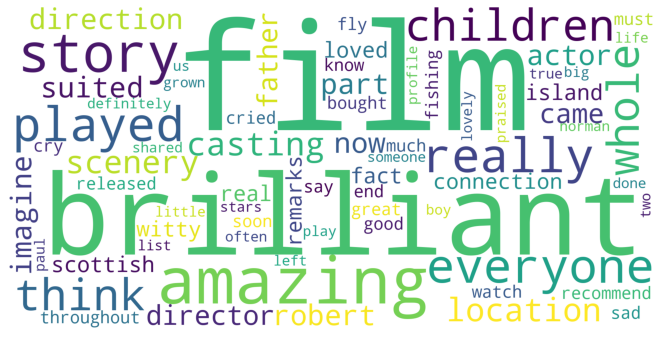

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

''' Convert Numerical Data to String Data '''
# convert this numeric review to a text review

# review -> numpy array

def to_text(review):

    word_idx = imdb.get_word_index() # Dict with the words mapped to numbers 
    idx_word = dict([value,key] for (key,value) in word_idx.items()) # invert dictionary

    # if there is no matching index value in the dict, -> ? is used
    # indices are offset by three because 0, 1, and 2 are reserved 
    # indices for “padding”, “start of sequence” and “unknown”
    actual_review = ' '.join([idx_word.get(ii-3,'?') for ii in review])

    print(f'\nReview:\n{actual_review}')
    print(f'\nLength of Review: {len(actual_review.split())}')
    
    print(f'\nWordcloud:')
    # Generate Word Cloud
    wordcloud = WordCloud(width = 2000, height = 1000, 
                          background_color ='white',
                          min_font_size = 10).generate(actual_review)

    plt.figure(figsize = (9,9),
               facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    
to_text(XTr[0])

In [6]:
''' Perform Padding '''

# Each review’s maximum length should be 500. 
# If it is less than that, then add extra 0’s at 
# the end of the array

X_train = pp.sequence.pad_sequences(XTr,maxlen=500)
X_test = pp.sequence.pad_sequences(XTe,maxlen=500)

print(XTr.shape)
print(X_train.shape)

print(f'Shape After Padding (X_train) : {X_train.shape}')
print(f'Shape After Padding (X_test)  : {X_test.shape}')
print("Padding Completed!")

(25000,)
(25000, 500)
Shape After Padding (X_train) : (25000, 500)
Shape After Padding (X_test)  : (25000, 500)
Padding Completed!


In [7]:
# Check the training data 
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,4472,113,103,32,15,16,5345,19,178,32
1,0,0,0,0,0,0,0,0,0,0,...,52,154,462,33,89,78,285,16,145,95
2,0,0,0,0,0,0,0,0,0,0,...,106,607,624,35,534,6,227,7,129,113
3,687,23,4,2,7339,6,3693,42,38,39,...,26,49,7008,15,566,30,579,21,64,2574
4,0,0,0,0,0,0,0,0,0,0,...,19,14,5,7224,6,226,251,7,61,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,5412,198,646,196,17,25,2537,12,17,1219
24996,0,0,0,0,0,0,0,0,0,0,...,7562,13,482,15,5902,2568,4,359,18,2
24997,0,0,0,0,0,0,0,0,0,0,...,1006,541,9303,7,4,59,2,4,3586,2
24998,0,0,0,0,0,0,0,0,0,0,...,5,2,12,38,84,80,124,12,9,23


In [8]:
''' Sequential Model '''
# Binary Classifier 

model = Sequential()
model.add(Embedding(10000,64))
model.add(SimpleRNN(32))
model.add(Dense(1,activation='sigmoid'))

# Compile Model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

print("Model Compiled Successfully!")

''' Callbacks '''

checkpoint = ModelCheckpoint("best_model.h5", 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False)

earlystop = EarlyStopping(monitor='val_acc',
                          patience=3)

''' Fit Model '''

hist = model.fit(X_train,YTr,
                 validation_split=0.2,
                 epochs=10,
                 batch_size=128,
                 callbacks=[checkpoint,earlystop])

Model Compiled Successfully!
Epoch 1/10
157/157 [==============================] - 81s 501ms/step - loss: 0.5639 - acc: 0.6997 - val_loss: 0.4028 - val_acc: 0.8330
Epoch 2/10
157/157 [==============================] - 78s 494ms/step - loss: 0.3424 - acc: 0.8603 - val_loss: 0.3583 - val_acc: 0.8454
Epoch 3/10
157/157 [==============================] - 78s 499ms/step - loss: 0.2451 - acc: 0.9053 - val_loss: 0.4006 - val_acc: 0.8568
Epoch 4/10
157/157 [==============================] - 77s 491ms/step - loss: 0.1750 - acc: 0.9370 - val_loss: 0.3772 - val_acc: 0.8544
Epoch 5/10
157/157 [==============================] - 78s 499ms/step - loss: 0.1183 - acc: 0.9583 - val_loss: 0.4876 - val_acc: 0.8024
Epoch 6/10
157/157 [==============================] - 79s 503ms/step - loss: 0.0677 - acc: 0.9786 - val_loss: 0.5194 - val_acc: 0.8096


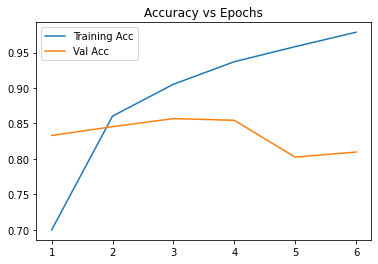

In [9]:
import matplotlib.pyplot as plt

acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(1,len(acc)+1)

plt.title("Accuracy vs Epochs")
plt.plot(epochs,acc,label="Training Acc")
plt.plot(epochs,val_acc,label="Val Acc")
plt.legend()
plt.show()

In [10]:
# It can be used to reconstruct the model identically.
reconstructed_model = load_model("best_model.h5")

def pred_imdb(sentence,model):

    inp = []
    print(f'Input sentence: \n{sentence}')

    # get dict mapper
    dict_word = imdb.get_word_index() # get dict mapper

    # convert words to int
    for word in sentence.split():
        if word in dict_word.keys():
            inp.append(dict_word[word])
        else:
            inp.append(1)

    print(f'Converted sentence: \n{inp}')

    # Perform padding
    final_input = pp.sequence.pad_sequences([inp],maxlen=500)

    # Finally predict the sentiment
    return model.predict(final_input)
    
sent = "This movie is really bad"
pred_imdb(sent,reconstructed_model)

Input sentence: 
This movie is really bad
Converted sentence: 
[1, 17, 6, 63, 75]


array([[0.5200373]], dtype=float32)